## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [3]:
df = pd.read_csv('StudentsPerformance.csv')

#### Show Top 5 Records

In [4]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Preparing X and Y variables

In [ ]:
X = df.drop(columns=['math score'],axis=1)
#getting droppign "maths score" from table columns

In [6]:
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [ ]:
#using all the other features (as independent features) to predict "math score" (dependent feature)
#thats why we got rid of maths column from the table

In [8]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race/ethnicity' variable:  ",end=" ")
print(df['race/ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental level of education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test preparation course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race/ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [9]:
y = df['math score']

In [10]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

In [ ]:
#the whole code is setting up this sorting and cleaning system.


# Create Column Transformer with 3 types of transformers

#only numerical features
num_features = X.select_dtypes(exclude="object").columns

#only categorical features
cat_features = X.select_dtypes(include="object").columns

# we combine OneHotEncoder, StandardScaler as a pipeline. column transformation will happen using "ColumnTransformer"
# OneHotEncoder turns words into numbers the computer understands.
# StandardScaler makes numbers more “fair” by shrinking or stretching them so they’re all on a similar scale.
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#ColumnTransformer is like a sorting machine
#giving back all the cleaned-up data together in one box
from sklearn.compose import ColumnTransformer



#initalizing
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

#responsible for transforming columns / data points
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [ ]:
#does 2 things:
#1. fit → The machine learns how to transform the data.
#2. transform → The machine actually changes the data.
X = preprocessor.fit_transform(X)


In [15]:
#prints entire array
X
X.shape

(1000, 19)

In [16]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

#### Create an Evaluate Function to give all metrics after model Training

In [ ]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    #thing of r2 score as "How good are my guesses compared to the real answers"
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [18]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7077
- Mean Absolute Error: 4.5167
- R2 Score: 0.8555
-----------------------

### Results

In [19]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.880433
5,Random Forest Regressor,0.851692
7,CatBoosting Regressor,0.851632
8,AdaBoost Regressor,0.850418
6,XGBRegressor,0.827797
1,Lasso,0.825320
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.708575


## Linear Regression

In [20]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.04


## Plot y_pred and y_test

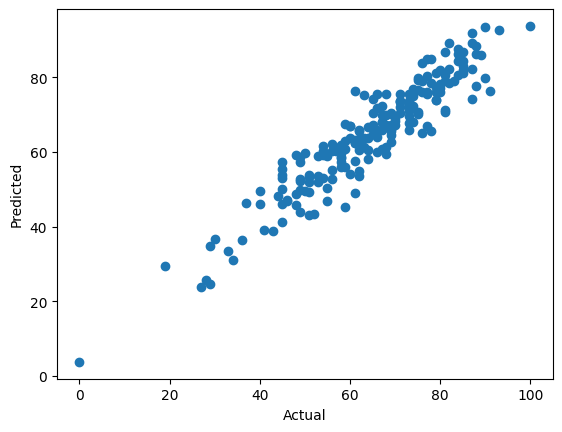

In [21]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

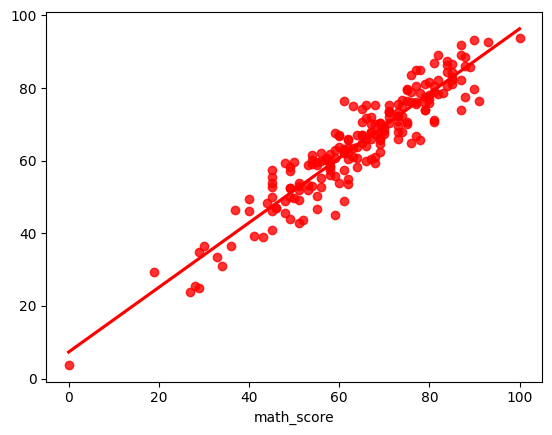

In [27]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [86]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

NameError: name 'y_pred' is not defined

Hyperparameter Practice

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import pandas as pd


In [ ]:
df = pd.read_csv('StudentsPerformance.csv')

In [ ]:
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [ ]:
X = df.drop(columns=['math score'],axis=1)
y = df["math score"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
#pipeline
numerical_preprocessor = Pipeline(

    steps = [

        ("imputation_mean", SimpleImputer(missing_values = np.nan, strategy = "mean")),
        ("scaler", StandardScaler())

    ]

)

In [ ]:
categorical_preprocessor = Pipeline(

    steps = [

        ("imputation_constant", SimpleImputer(fill_value = "missing", strategy = "constant")),
        ("onehot", OneHotEncoder(handle_unknown = "ignore"))

    ]

)

In [ ]:
#combining both processors together

preprocessor = ColumnTransformer(

    [

    ("categorical", categorical_preprocessor, ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course"]),
    ("numerical", numerical_preprocessor, ["reading score", "writing score"])

]

)

In [ ]:
pipe = Pipeline(

    steps = [
        
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(random_state=42))

    ]

)

In [ ]:
from sklearn import set_config

In [ ]:
set_config(display = 'diagram')

In [ ]:
pipe

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
pipe.predict(X_train)

array([72.8       , 88.99      , 57.65      , 68.15      , 59.47      ,
       47.91      , 57.4       , 48.        , 60.67      , 61.33      ,
       48.7       , 47.22      , 84.48      , 71.47      , 62.3       ,
       61.56      , 68.73      , 93.58      , 52.86      , 91.79      ,
       65.27      , 51.58      , 65.69      , 83.93      , 71.03      ,
       55.98      , 58.56      , 41.05      , 69.59      , 75.28      ,
       59.26      , 79.66      , 89.14      , 74.89      , 53.68      ,
       70.57      , 62.05      , 68.19      , 48.01      , 52.11      ,
       24.38      , 94.42      , 70.84      , 62.49      , 65.55      ,
       88.6       , 90.03      , 79.82      , 71.91      , 58.51      ,
       69.3       , 71.81      , 57.        , 84.78      , 52.51      ,
       69.83      , 53.48      , 66.62      , 89.29      , 54.26      ,
       64.62      , 71.44      , 79.        , 60.24      , 50.47      ,
       62.23      , 88.61      , 48.98      , 60.98      , 62.28

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#hyperparameter tuning

param_grid = {

    "regressor__n_estimators": [200,500],
    "regressor__max_features": ["auto", "sqrt", "log2"],
    "regressor__max_depth": [4, 5, 6, 7, 8]

}

In [ ]:
grid_search = GridSearchCV(pipe, param_grid = param_grid, n_jobs = -1)

In [ ]:
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [4, 5, ...], 'regressor__max_features': ['auto', 'sqrt', ...], 'regressor__n_estimators': [200, 500]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('categorical', ...), ('numerical', ...)]"


In [ ]:
grid_search.best_params_

{'regressor__max_depth': 8,
 'regressor__max_features': 'sqrt',
 'regressor__n_estimators': 200}

In [ ]:
pipe = Pipeline(

    steps = [
        
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(max_depth = 8,
                                            max_features = "sqrt",
                                            n_estimators = 200))
                                            
    ]

)

In [ ]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
pipe.predict(X_test)

array([74.77659022, 44.99541077, 61.16433821, 54.66815431, 70.04462186,
       70.86951168, 79.84765955, 75.30236053, 48.58921281, 66.63445416,
       70.05641779, 78.04536813, 47.99813885, 83.8588479 , 66.99205059,
       66.8590102 , 65.48358264, 64.15928842, 36.61601123, 70.25855206,
       73.14600866, 65.8738664 , 68.44058765, 81.39278086, 62.78225881,
       74.66653816, 54.10538272, 27.67612336, 58.4165496 , 46.56706863,
       61.24592801, 91.17786423, 64.16270161, 62.948639  , 72.47681283,
       66.77067648, 55.93367264, 65.28800155, 85.96231871, 52.50565263,
       66.76314358, 52.26882435, 48.85265312, 68.27803216, 80.14234552,
       63.19264531, 84.21855639, 79.89702885, 51.50994378, 68.89396307,
       69.58549484, 48.23698193, 66.31632741, 58.21364602, 48.63119522,
       69.59220968, 57.13264653, 82.4967113 , 62.62418823, 34.40100931,
       68.18300936, 45.3900652 , 83.67556146, 55.33809293, 82.00011394,
       81.81421346, 72.9237697 , 62.82252364, 67.03032133, 70.30